In [1]:
import math
import mrcfile
import os
from glob import glob
import multiprocessing as mp
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
import scipy.interpolate
import time

from ipywidgets import *
from matplotlib.widgets import Slider

from scipy.interpolate import RegularGridInterpolator
from Bio.PDB import PDBParser
from PIL import Image
from pathlib import Path
from scipy.spatial.transform import Rotation

%matplotlib inline

DEFAULT_DIM = [1024,1024,400] # dimension of tomogram in pixels
DEFAULT_APIX = 2.65 # angstrom/pixel factor
DEFAULT_RANG = 40 # radius of interest in angstroms
DEFAULT_RPIX = DEFAULT_RANG/DEFAULT_APIX # radius of interest in pixels
DEFAULT_NTHREADS = int(3*mp.cpu_count()/4) # number of threads for parallel processing

workDir="/ChangLab5-hd2/hannah/data/test/"
tomoFiles = list(glob(os.path.join(workDir,"tomograms","TS16_unblur_orig__bin4.hdf")))
segFiles = list(glob(os.path.join(workDir,"segmentations","*.pdb")))

tomoFile = tomoFiles[0]
segFile = segFiles[0]

In [96]:
# Get tomogram file
def getTomo(tomoFile):
    hf = h5py.File(tomoFile)
    data = hf.get('/MDF/images/0/image')
    return data[:]
        
# Get filaments from segmentation file
def getSeg(segFile):
    pdbParser = PDBParser()  
    structure = pdbParser.get_structure("microtubule", segFile)
    # dict of {chain ID : [xpos, ypos, zpos]}
    for model in structure:
        filaments = {} 
        for filament in model:
            atoms = filament.get_atoms()
            b = len([_ for _ in filament.get_atoms()])
            positions = np.zeros([3,b],dtype=float)
            i=0
            for atom in atoms:
                coord = atom.get_coord()
                for j in range(3):
                    positions[j,i] = coord[j]
                i=i+1
            filaments[filament.get_id()] = positions.T
    return filaments

# View 3D image through 2D projections along z-axis
def sliceShow(image):
    fig= plt.figure()
    ax=fig.add_subplot(111)
    ax.imshow(image[:,:,0])
    slider_ax = fig.add_axes([0.2, 0, 0.6, 0.05])
    samp = Slider(slider_ax, 'slice', 0, image.shape[2]-1, valinit=0,valstep=1)
    def update(val):
        ax.imshow(image[:,:,samp.val])
        fig.canvas.draw_idle()
    samp.on_changed(update);
    
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Calculate orthogonal distance of point to line segment
# p - test point, a - line segment point 1, b - line segment point 2
def lineseg_dist(p, a, b):
    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))
    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)
    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])
    # perpendicular distance component
    c = np.cross(p - a, d)
    return np.hypot(h, np.linalg.norm(c))

# Down/Upscale a 3D image
def rescale(image, filament=None, binFactor=16, scaleDown=True):
    binArray = binFactor*np.ones(3)
    if scaleDown:
        steps = [1,1,1]    # original step sizes
        dx, dy, dz = binArray   # new step sizes
        if filament is not None:
            filament_new = np.divide(filament, binArray)
    else:
        steps = binArray    # original step sizes
        dx, dy, dz = [1,1,1]   # new step sizes
        if filament is not None:
            filament_new = np.multiply(filament, binArray)        
    x, y, z = [steps[k] * np.arange(image.shape[k]) for k in range(3)]  # original grid
    f = RegularGridInterpolator((x, y, z), image, method="nearest")    # interpolator
    new_grid = np.mgrid[0:x[-1]:dx, 0:y[-1]:dy, 0:z[-1]:dz]   # new grid
    new_grid = np.moveaxis(new_grid, (0, 1, 2, 3), (3, 0, 1, 2))  # reorder axes for evaluation
    image_new = f(new_grid)
    if filament is not None:
        return image_new, filament_new
    else:
        return image_new

# Find pixels within radius of line formed by two endpoints, adding spheres at each endpoints
def inSegImage(filament, r=DEFAULT_RPIX, dim=DEFAULT_DIM, binFactor=None, mask = None):
    image = np.zeros(dim)
    n = filament.shape[0] # number of points defining the segmentation
    # apply binning if needed
    if binFactor is not None:
        image, filament = rescale(image, filament=filament, binFactor=binFactor, scaleDown=True)
        dim = image.shape
    # no mask
    if mask is None:
        for x in range(dim[0]):
            for y in range(dim[1]):
                for z in range(dim[2]):
                    # if the point is not already marked...
                    if image[x,y,z] == 0:
                        p = np.array([x,y,z])+0.5
                        # for each pair of line segments...
                        for i in range(n-1):
                            # is the point near the sphere about the start segment point?
                            if np.linalg.norm(p - filament[i]) <= r:
                                image[x,y,z] = 1
                                break
                            # is the point near the cylinder about the line formed by two segment points?
                            elif lineseg_dist(p, filament[i], filament[i+1]) <= r:
                                image[x,y,z] = 1
                                break
                        # is the point in the sphere about the end point
                        if np.linalg.norm(p - filament[n-1]) <= r:
                            image[x,y,z] = 1
    # apply mask
    else:
        # rescale mask if binFactor given
        if binFactor is not None:
            mask = rescale(mask, filament = None, binFactor=binFactor, scaleDown=True)
        coords = np.argwhere(mask)
        for x, y, z in coords:
            # if the point is not already marked...
            if image[x,y,z] == 0:
                p = np.array([x,y,z])+0.5
                # for each pair of line segments...
                for i in range(n-1):
                    # is the point near the sphere about the start segment point?
                    if np.linalg.norm(p - filament[i]) <= r:
                        image[x,y,z] = 1
                        break
                    # is the point near the cylinder about the line formed by two segment points?
                    elif lineseg_dist(p, filament[i], filament[i+1]) <= r:
                        image[x,y,z] = 1
                        break
                # is the point in the sphere about the end point
                if np.linalg.norm(p - filament[n-1]) <= r:
                    image[x,y,z] = 1
    # convert back into original coordinates for binning
    if binFactor is not None:
        image, filament = rescale(image, filament=filament, binFactor=binFactor,scaleDown=False)
    return image

# Creates a rotation matrix that aligns two vectors
def genRotMatrix(vec1, vec2=np.array([0, 0, 1])):
    vec1 = np.reshape(vec1, (1, -1))
    vec2 = np.reshape(vec2, (1, -1))
    r = Rotation.align_vectors(vec1, vec2)
    return r[0].as_matrix()

# Returns a list of integer coordinates within a cylinder
def genCylCoords(start, end, r, axisFactor=1, thetaN=180, rFactor=1.1):
    height = np.linalg.norm(end-start)
    axisN = int(axisFactor*np.ceil(height))+1
    rN = int(rFactor*r)
    axisList = np.append(np.zeros([axisN,2]), np.array([np.linspace(-height/2,height/2,axisN)]).T ,axis=1)
    thetaList = np.linspace(0, 2*math.pi, thetaN)
    rList = np.linspace(0, r, rN)
    coords = np.zeros([axisList.size,rList.size,thetaList.size,3])
    for i, axis in enumerate(axisList):
        for j, r in enumerate(rList):
            for k, t in enumerate(thetaList):
                coords[i,j,k,:] = axis + [r*math.cos(t),r*math.sin(t),0]
    # list of float coordinates that are within a cylinder whose axis is parallel to the z axis and origin at zero
    coords = np.reshape(coords,[axisList.size*rList.size*thetaList.size,3])
    # rotated cylinder
    coords = np.unique(((genRotMatrix(end-start).dot(coords.T)).T+np.mean([start,end],axis=0)).astype(int),axis=0)
    return coords

# Returns a list of integer coordinates within a sphere
def genSphereCoords(point, r, thetaN=180, rFactor=1.1):
    phiN = int(thetaN/2)
    rN = int(rFactor*r)
    phiList = np.linspace(0, math.pi, phiN)
    thetaList = np.linspace(0, 2*math.pi, thetaN)
    rList = np.linspace(0, r, rN)
    coords = np.zeros([phiList.size,rList.size,thetaList.size,3])
    for i, p in enumerate(phiList):
        for j, r in enumerate(rList):
            for k, t in enumerate(thetaList):
                coords[i,j,k,:] = point + [r*math.sin(p)*math.cos(t),r*math.sin(p)*math.sin(t),r*math.cos(p)]
    coords = np.reshape(coords,[phiList.size*rList.size*thetaList.size,3])
    coords = np.unique((coords).astype(int),axis=0)
    return coords

# Find pixels within radius of line formed by two endpoints, adding spheres at each endpoints
def inSegImage2(filament, r=DEFAULT_RPIX, dim=DEFAULT_DIM):
    image = np.zeros(dim)
    n = filament.shape[0] # number of points defining the segmentation
    coords = []
    # get first sphere
    coords = genSphereCoords(filament[0], r)
    # subsequent
    for i in range(n-1):
        # get cylinder surrounding the line segment between points
        coords = np.append(coords,genCylCoords(filament[i],filament[i+1],r), axis=0)
        # get sphere around end point
        coords = np.append(coords,genSphereCoords(filament[i+1],r), axis=0)
    # keep only unique values
    coords = np.unique(coords,axis=0).astype(int)
    # remove invalid coordinates
    coords[(coords[:,0]<dim[0]) * (coords[:,1]<dim[1]) * (coords[:,2]<dim[2])]
    # fill image
    for x,y,z in coords:
        if (x>=dim[0]) or (y>=dim[0]) or (z>=dim[0]):
            continue
        image[x,y,z] = 1
    return image

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Find pixels that are "near" a filament (a series of segments)
def inFilImageParallel(filaments, r=DEFAULT_RPIX, dim=[1024,1024,400], nThreads=DEFAULT_NTHREADS):
    
    # init multiprocessing.Pool()
    pool = mp.Pool(nThreads)
    # use `pool.apply` to divide work up per filament
    results = [pool.apply(inSegImage2, args=(filament, r, dim)) for filament in filaments] 
    # close pool
    pool.close()
    pool.join() 
    # mask together so that the resulting masks are added together (logical or)
    image = np.logical_or.reduce(results)
    # image - masked together, results - list of 3D images, one for each filament 
    return image, results

In [ ]:
%matplotlib notebook

start = np.array([-16,-32,-20])
end = np.array([15,8,37])
axLim = 50
r = DEFAULT_RPIX

cylCoords = genCylCoords(start, end, r)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(cylCoords[:,0],cylCoords[:,1],cylCoords[:,2], facecolors='b');
ax.scatter3D([start[0]],[start[1]],[start[2]], facecolors='g',s=100);
ax.scatter3D([end[0]],[end[1]],[end[2]], facecolors='r',s=100);
ax.set_box_aspect(aspect = (1,1,1))
ax.axes.set_xlim3d(left=-axLim, right=axLim) 
ax.axes.set_ylim3d(bottom=-axLim, top=axLim) 
ax.axes.set_zlim3d(bottom=-axLim, top=axLim)
ax.axes.set_xlabel("x")
ax.axes.set_ylabel("y")
ax.axes.set_zlabel("z")
plt.show()

/tmp/ipykernel_165088/2740741488.py:139: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = Rotation.align_vectors(vec1, vec2)


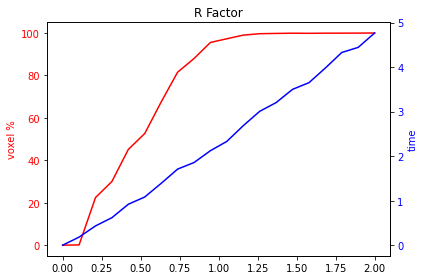

In [84]:
# R FACTOR CYLINDER

%matplotlib inline

n=20
y = np.zeros([n])
x = np.linspace(0,2,n)
t = np.zeros([n])
for i, xi in enumerate(x):
    start_time = time.time()
    y[i] = genCylCoords(start, end, r, rFactor=xi).shape[0]
    t[i] = time.time() - start_time
    
fig, ax1 = plt.subplots()

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax1 = plt.axes()
ax1.set_title("R Factor")
ax1.plot(x,100*y/np.max(y), color="r")
ax1.set_ylabel('voxel %', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx() 
ax2.plot(x,t, color="b")
ax2.set_ylabel('time', color="b")
ax2.tick_params(axis='y', labelcolor="b")

fig.tight_layout() 

plt.savefig('RFactor_Cyl.png')

/tmp/ipykernel_165088/2740741488.py:139: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = Rotation.align_vectors(vec1, vec2)


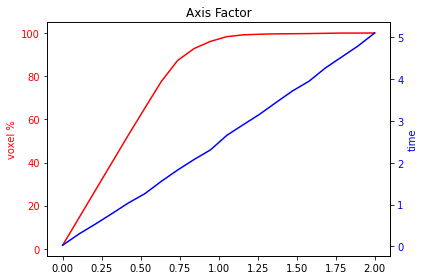

In [85]:
# AXIS FACTOR CYLINDER

%matplotlib inline

n=20
y = np.zeros([n])
x = np.linspace(0,2,n)
t = np.zeros([n])
for i, xi in enumerate(x):
    start_time = time.time()
    y[i] = genCylCoords(start, end, r, axisFactor=xi).shape[0]
    t[i] = time.time() - start_time
    
fig, ax1 = plt.subplots()

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax1 = plt.axes()
ax1.set_title("Axis Factor")
ax1.plot(x,100*y/np.max(y), color="r")
ax1.set_ylabel('voxel %', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx() 
ax2.plot(x,t, color="b")
ax2.set_ylabel('time', color="b")
ax2.tick_params(axis='y', labelcolor="b")

fig.tight_layout() 

plt.savefig('AxisFactor_Cyl.png')

/tmp/ipykernel_165088/2740741488.py:139: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r = Rotation.align_vectors(vec1, vec2)


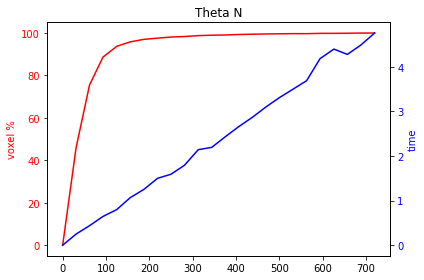

In [86]:
# THETA N CYLINDER

%matplotlib inline

n=24
y = np.zeros([n])
x = np.linspace(0,720,n,dtype=int)
t = np.zeros([n])
for i, xi in enumerate(x):
    start_time = time.time()
    y[i] = genCylCoords(start, end, r, thetaN=xi).shape[0]
    t[i] = time.time() - start_time
    
fig, ax1 = plt.subplots()

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax1 = plt.axes()
ax1.set_title("Theta N")
ax1.plot(x,100*y/np.max(y), color="r")
ax1.set_ylabel('voxel %', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx() 
ax2.plot(x,t, color="b")
ax2.set_ylabel('time', color="b")
ax2.tick_params(axis='y', labelcolor="b")

fig.tight_layout() 

plt.savefig('ThetaN_Cyl.png')

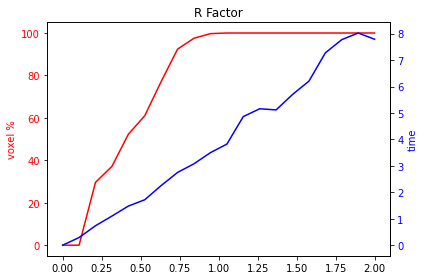

In [87]:
# R FACTOR SPHERE

%matplotlib inline

n=20
y = np.zeros([n])
x = np.linspace(0,2,n)
t = np.zeros([n])
for i, xi in enumerate(x):
    start_time = time.time()
    y[i] = genSphereCoords(start, r, rFactor=xi).shape[0]
    t[i] = time.time() - start_time
    
fig, ax1 = plt.subplots()

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax1 = plt.axes()
ax1.set_title("R Factor")
ax1.plot(x,100*y/np.max(y), color="r")
ax1.set_ylabel('voxel %', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx() 
ax2.plot(x,t, color="b")
ax2.set_ylabel('time', color="b")
ax2.tick_params(axis='y', labelcolor="b")

fig.tight_layout() 

plt.savefig('RFactor_Sphere.png')

In [ ]:
# THETA N SPHERE

%matplotlib inline

n=24
y = np.zeros([n])
x = np.linspace(0,360,n,dtype=int)
t = np.zeros([n])
for i, xi in enumerate(x):
    start_time = time.time()
    y[i] = genSphereCoords(start, r, thetaN=xi).shape[0]
    t[i] = time.time() - start_time
    
fig, ax1 = plt.subplots()

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax1 = plt.axes()
ax1.set_title("Theta N")
ax1.plot(x,100*y/np.max(y), color="r")
ax1.set_ylabel('voxel %', color="r")
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx() 
ax2.plot(x,t, color="b")
ax2.set_ylabel('time', color="b")
ax2.tick_params(axis='y', labelcolor="b")

fig.tight_layout() 

plt.savefig('ThetaN_Sphere.png')

<IPython.core.display.Javascript object>


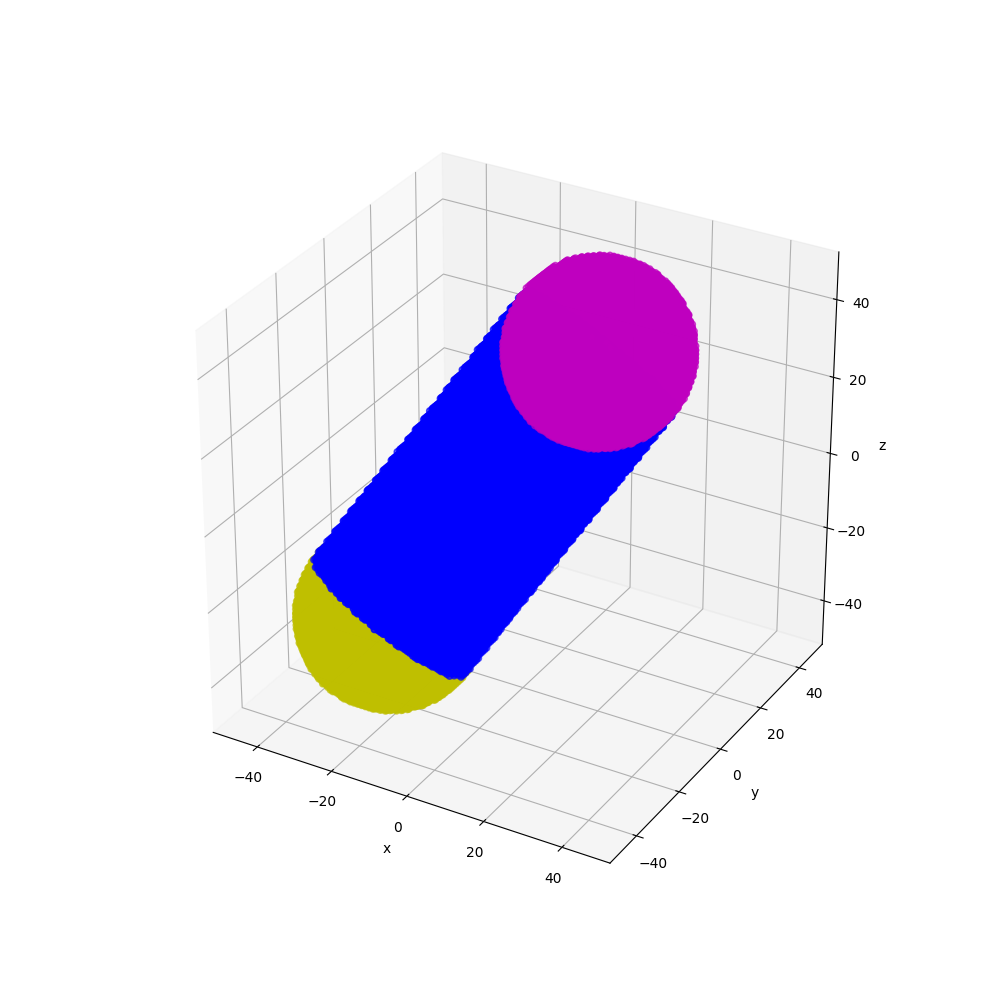

In [4]:
%matplotlib notebook

sphCoords1 = genSphereCoords(start, r)
sphCoords2 = genSphereCoords(end, r)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(cylCoords[:,0],cylCoords[:,1],cylCoords[:,2], facecolors='b');
ax.scatter3D(sphCoords1[:,0],sphCoords1[:,1],sphCoords1[:,2], facecolors='y');
ax.scatter3D(sphCoords2[:,0],sphCoords2[:,1],sphCoords2[:,2], facecolors='m');
ax.scatter3D([start[0]],[start[1]],[start[2]], facecolors='g',s=100);
ax.scatter3D([end[0]],[end[1]],[end[2]], facecolors='r',s=100);
ax.set_box_aspect(aspect = (1,1,1))
ax.axes.set_xlim3d(left=-axLim, right=axLim) 
ax.axes.set_ylim3d(bottom=-axLim, top=axLim) 
ax.axes.set_zlim3d(bottom=-axLim, top=axLim)
ax.axes.set_xlabel("x")
ax.axes.set_ylabel("y")
ax.axes.set_zlabel("z")
plt.show()